# Projeto Previsão de Churn Rate

### A pergunta inicial e se existe uma correlação entre as variaveis do data-set e com o qual precisão o modelo pode prever a porbabilidade de um cliente evadir

### Variaveis
- Churn: Yes or Not 
- Contract: Month-to-month , One year, Two year
- Dependents: Yes or Not
- DeviceProtection: Yes or Not
- InternetService: Fiber Optic, DSL, No 
- MonthlyCharges= How much the customer spent per month
- MultipleLines: Yes or Not
- OnlineBackup: Yes or Not 
- OnlineSecurity: Yes or Not
- PaperlessBilling: Yes or Not
- Partner: Yes or Not
- PaymentMethod: Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic)
- PhoneService: Yes or Not 
- SeniorCitizen: 0 or 1
- StreamingMovies: Yes or Not
- StreamingTV: Yes or Not
- TechSupport: Yes or Not
- TotalCharges= how much the customer spent in total
- customerID: ID
- gender: The customer is a male or a female
- tenure = Months The customer has stayed with the company

Importando bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from scikitplot.metrics import plot_precision_recall_curve, plot_lift_curve, plot_cumulative_gain, plot_roc_curve, plot_ks_statistic
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
sns.set()

Chamando arquivo

In [2]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

Vendo tamanho do arquivo e informações do arquivo

### Análise exploratória

In [3]:
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.shape

(7043, 21)

### Preparação e limpeza dos dados

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Convertendo total charges em numerico e encontrando se há valores missing

In [6]:
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

Entendendo os valores Missing

In [7]:
df['TotalCharges'].sort_values().tail(11)

488    NaN
753    NaN
936    NaN
1082   NaN
1340   NaN
3331   NaN
3826   NaN
4380   NaN
5218   NaN
6670   NaN
6754   NaN
Name: TotalCharges, dtype: float64

In [8]:
df['tenure'].value_counts()

1     613
72    362
2     238
3     200
4     176
     ... 
28     57
39     56
44     51
36     50
0      11
Name: tenure, Length: 73, dtype: int64

Sabemos que os valores de TotalCharges = tenure x MontlyCharges

Sendo assim, Vamos investigar os valores para podermos entender melhor

In [9]:
df[['tenure','MonthlyCharges','TotalCharges']].head()

,tenure,MonthlyCharges,TotalCharges
0,1,29.85,29.85
1,34,56.95,1889.50
2,2,53.85,108.15
3,45,42.30,1840.75
4,2,70.70,151.65


Podemos notar que todos os valores zerados em tenure tem o mesmo Id dos NaN de TotalCharges

In [10]:
df.query('tenure=="0"').head(11)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


Agora vamos retirar os dados missing simplesmente tranformando o 0 em 1 pois entendemos que os clientes com 0 assinaram o plano a menos de 1 mês mas já começaram a pagar.

In [11]:
df.loc[df['tenure']==0, 'tenure'] = 1

In [12]:
#df['tenuere'] = df['tenure'].map({0:1})

In [13]:
#df['tenure'] = df['tenure'].rename({0:1})

In [14]:
df['tenure'].value_counts()

1     624
72    362
2     238
3     200
4     176
     ... 
38     59
28     57
39     56
44     51
36     50
Name: tenure, Length: 72, dtype: int64

Agora vamos fazer o cauculo para acabar de vez com os dados missing.

In [15]:
df['TotalCharges'] = df['TotalCharges'].fillna(df['tenure']*df['MonthlyCharges'])

In [16]:
df.query('tenure=="0"').head(11)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


Agora nos tranforaremos os dados que os clientes não tem determinado tipo de servço em não para podermos trabalhar com as variavris binarias.

In [17]:
df.loc[df['StreamingMovies']=='No internet service', 'StreamingMovies'] = 'No'
df.loc[df['StreamingTV']=='No internet service', 'StreamingTV'] = 'No'
df.loc[df['OnlineSecurity']=='No internet service', 'OnlineSecurity'] = 'No'
df.loc[df['OnlineBackup']=='No internet service', 'OnlineBackup'] = 'No'
df.loc[df['DeviceProtection']=='No internet service', 'DeviceProtection'] = 'No'
df.loc[df['TechSupport']=='No internet service', 'TechSupport'] = 'No'
df.loc[df['OnlineSecurity']=='No internet service', 'OnlineSecurity'] = 'No'
df.loc[df['MultipleLines']=='No phone service', 'MultipleLines'] = 'No'

Agora vamos tranformas os Yes ou Not em argumentos binarios 1 ou 0

Não esquecer e especificar a colina após o DF que você quer modificar!

In [18]:
transform = OrdinalEncoder()

In [19]:
col_bin = ['Churn','gender', 'Partner','Dependents','PhoneService','StreamingTV','PaperlessBilling','StreamingMovies','OnlineSecurity',
           'OnlineBackup', 'DeviceProtection', 'TechSupport', 'OnlineSecurity', 'MultipleLines']
df[col_bin] = pd.DataFrame(pd.DataFrame(columns=col_bin, data=transform.fit_transform(df[col_bin])))

Agora tranformamos as colunas categoricas menos customerID em colunas

In [20]:
Cat = ['InternetService', 'Contract', 'PaymentMethod']
df = pd.get_dummies(df, columns=Cat)

In [21]:
df[['tenure','MonthlyCharges','TotalCharges']].head(489)

,tenure,MonthlyCharges,TotalCharges
0,1,29.85,29.85
1,34,56.95,1889.50
2,2,53.85,108.15
3,45,42.30,1840.75
4,2,70.70,151.65
...,...,...,...
484,8,83.55,680.05
485,72,84.50,6130.85
486,15,100.15,1415.00
487,72,88.60,6201.95


## Vamos iniciar a analise exploratoria dos dados

In [22]:
corr_matrix = df.corr()

In [23]:
corr_matrix["Churn"].sort_values(ascending=False)

Churn                                      1.000000
Contract_Month-to-month                    0.405103
InternetService_Fiber optic                0.308020
PaymentMethod_Electronic check             0.301919
MonthlyCharges                             0.193356
PaperlessBilling                           0.191825
SeniorCitizen                              0.150889
StreamingTV                                0.063228
StreamingMovies                            0.061382
MultipleLines                              0.040102
PhoneService                               0.011942
gender                                    -0.008612
DeviceProtection                          -0.066160
OnlineBackup                              -0.082255
PaymentMethod_Mailed check                -0.091683
PaymentMethod_Bank transfer (automatic)   -0.117937
InternetService_DSL                       -0.124214
PaymentMethod_Credit card (automatic)     -0.134302
Partner                                   -0.150448
Dependents  

In [24]:
df[['tenure','Contract_Month-to-month','Contract_One year','Contract_Two year','Churn']].head(20)

,tenure,Contract_Month-to-month,Contract_One year,Contract_Two year,Churn
0,1,1,0,0,0.0
1,34,0,1,0,0.0
2,2,1,0,0,1.0
3,45,0,1,0,0.0
4,2,1,0,0,1.0
5,8,1,0,0,1.0
6,22,1,0,0,0.0
7,10,1,0,0,0.0
8,28,1,0,0,1.0
9,62,0,1,0,0.0


In [25]:
df[['tenure','TotalCharges', 'Churn']].head(20)

,tenure,TotalCharges,Churn
0,1,29.85,0.0
1,34,1889.50,0.0
2,2,108.15,1.0
3,45,1840.75,0.0
4,2,151.65,1.0
5,8,820.50,1.0
6,22,1949.40,0.0
7,10,301.90,0.0
8,28,3046.05,1.0
9,62,3487.95,0.0


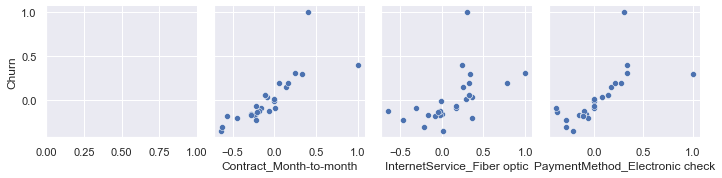

In [26]:
sns.pairplot(data=corr_matrix, x_vars=[" ","Contract_Month-to-month", "InternetService_Fiber optic", "PaymentMethod_Electronic check"], y_vars=["Churn"])

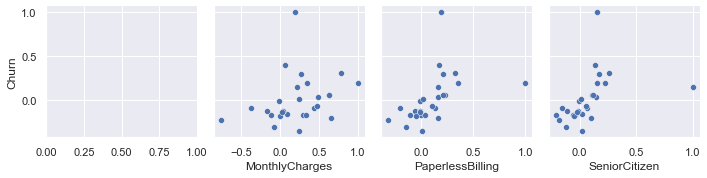

In [27]:
sns.pairplot(data=corr_matrix, x_vars=[" ","MonthlyCharges", "PaperlessBilling", "SeniorCitizen"], y_vars=["Churn"])

### Seleção de atributos

<AxesSubplot:xlabel='Churn', ylabel='SeniorCitizen'>

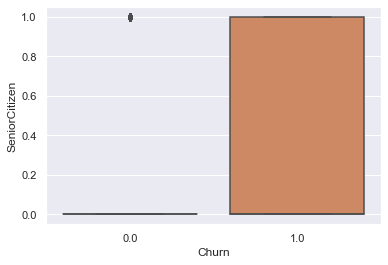

In [28]:
sns.boxplot(data=df, x="Churn", y="SeniorCitizen")

<AxesSubplot:xlabel='Churn', ylabel='Contract_Month-to-month'>

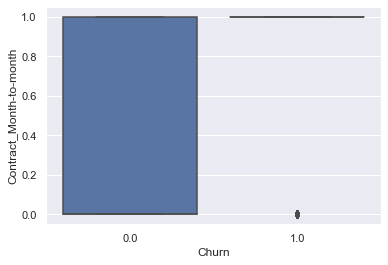

In [29]:
sns.boxplot(data=df, x="Churn", y="Contract_Month-to-month")

<AxesSubplot:xlabel='Churn', ylabel='InternetService_Fiber optic'>

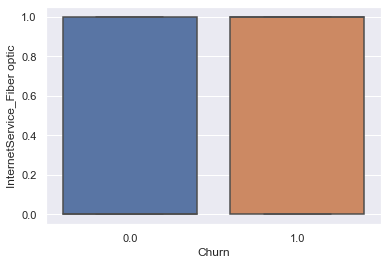

In [30]:
sns.boxplot(data=df, x="Churn", y="InternetService_Fiber optic")

<AxesSubplot:xlabel='Churn', ylabel='PaymentMethod_Electronic check'>

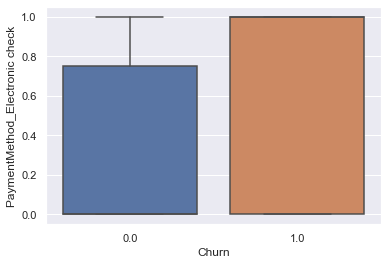

In [31]:
sns.boxplot(data=df, x="Churn", y="PaymentMethod_Electronic check")

In [32]:
df2 = df.drop("customerID", axis=1)

### Construção do modelo

In [33]:
X = df2.drop("Churn", axis=1)
Y = df2["Churn"]

In [34]:
X_train , X_test , Y_train, Y_test = train_test_split(X,Y ,random_state=42, test_size=0.2, stratify=Y)

In [35]:
lreg = LogisticRegression()
tree_clas = ExtraTreesClassifier()
rf = RandomForestClassifier()
xgb = XGBClassifier()
cat = CatBoostClassifier()

In [36]:
lreg.fit(X_train, Y_train)

C:\Users\Thiago\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [37]:
Y_lreg_pred = lreg.predict(X_test)
Y_lreg_pred_proba = lreg.predict_proba(X_test)
Y_lreg_pred

array([0., 1., 0., ..., 0., 0., 0.])

In [38]:
Y_lreg_pred==Y_test

437      True
2280    False
2235     True
4460     True
3761     True
        ...  
5143     True
4439     True
3857     True
4758     True
5613     True
Name: Churn, Length: 1409, dtype: bool

Fazer a calibração do modelo

In [39]:
calibrated_tree = CalibratedClassifierCV(base_estimator=tree_clas, cv=3)
calibrated_tree.fit(X_train, Y_train)

CalibratedClassifierCV(base_estimator=ExtraTreesClassifier(), cv=3)

In [40]:
y_tree_pred = calibrated_tree.predict(X_test)
y_tree_pred_proba = calibrated_tree.predict_proba(X_test)
y_tree_pred

array([0., 1., 0., ..., 0., 0., 0.])

In [41]:
Y_test.values

array([0., 0., 0., ..., 0., 0., 0.])

In [42]:
calibrated_rf = CalibratedClassifierCV(base_estimator=rf, cv=3)
calibrated_rf.fit(X_train, Y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(), cv=3)

In [43]:
y_rf_pred = calibrated_rf.predict(X_test)
y_rf_pred_proba = calibrated_rf.predict_proba(X_test)
y_rf_pred

array([0., 1., 0., ..., 0., 0., 0.])

In [44]:
calibrated_xgb = CalibratedClassifierCV(base_estimator=xgb, cv=3)
calibrated_xgb.fit(X_train, Y_train)

C:\Users\Thiago\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:22:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Thiago\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:22:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Thiago\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:22:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=None,
                                                    booster=None,
                                                    colsample_bylevel=None,
                                                    colsample_bynode=None,
                                                    colsample_bytree=None,
                                                    gamma=None, gpu_id=None,
                                                    importance_type='gain',
                                                    interaction_constraints=None,
                                                    learning_rate=None,
                                                    max_delta_step=None,
                                                    max_depth=None,
                                                    min_child_weight=None,
                                                    missing=nan,
                                                   

In [45]:
y_xgb_pred = calibrated_xgb.predict(X_test)
y_xgb_pred_proba = calibrated_xgb.predict_proba(X_test)
y_xgb_pred

C:\Users\Thiago\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\Thiago\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


array([0., 1., 0., ..., 0., 0., 0.])

In [46]:
y_xgb_pred_proba

array([[0.9024831 , 0.0975169 ],
       [0.19064144, 0.80935856],
       [0.85357363, 0.14642637],
       ...,
       [0.88070028, 0.11929972],
       [0.84317985, 0.15682015],
       [0.90304769, 0.09695231]])

In [47]:
calibrated_cat = CalibratedClassifierCV(base_estimator=cat, cv=3)
calibrated_cat.fit(X_train, Y_train)

Learning rate set to 0.018128
0:	learn: 0.6807747	total: 124ms	remaining: 2m 3s
1:	learn: 0.6689004	total: 144ms	remaining: 1m 12s
2:	learn: 0.6572445	total: 160ms	remaining: 53.3s
3:	learn: 0.6464874	total: 174ms	remaining: 43.4s
4:	learn: 0.6370392	total: 186ms	remaining: 37.1s
5:	learn: 0.6264035	total: 199ms	remaining: 33s
6:	learn: 0.6185585	total: 204ms	remaining: 29s
7:	learn: 0.6099425	total: 216ms	remaining: 26.8s
8:	learn: 0.6016728	total: 224ms	remaining: 24.6s
9:	learn: 0.5933093	total: 236ms	remaining: 23.4s
10:	learn: 0.5851747	total: 251ms	remaining: 22.6s
11:	learn: 0.5777350	total: 260ms	remaining: 21.4s
12:	learn: 0.5702865	total: 268ms	remaining: 20.3s
13:	learn: 0.5635014	total: 276ms	remaining: 19.5s
14:	learn: 0.5571599	total: 284ms	remaining: 18.7s
15:	learn: 0.5517470	total: 293ms	remaining: 18s
16:	learn: 0.5456906	total: 302ms	remaining: 17.5s
17:	learn: 0.5402055	total: 310ms	remaining: 16.9s
18:	learn: 0.5357187	total: 319ms	remaining: 16.5s
19:	learn: 0.530

CalibratedClassifierCV(base_estimator=<catboost.core.CatBoostClassifier object at 0x000001E42476B040>,
                       cv=3)

In [48]:
y_cat_pred = calibrated_cat.predict(X_test)
y_cat_pred_proba = calibrated_cat.predict_proba(X_test)
y_cat_pred

array([0., 1., 0., ..., 0., 0., 0.])

### Avaliação do modelo

AUC Acima de 0.5
AUC abaixo de 0.5 chute
Calibrar as probabiidades depois da saida
plotar AUC
Plotar KS

In [49]:
print(classification_report(Y_test, Y_lreg_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.89      0.87      1035
         1.0       0.66      0.56      0.61       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409



In [50]:
print(classification_report(Y_test, y_tree_pred))

              precision    recall  f1-score   support

         0.0       0.81      0.92      0.86      1035
         1.0       0.64      0.39      0.48       374

    accuracy                           0.78      1409
   macro avg       0.72      0.65      0.67      1409
weighted avg       0.76      0.78      0.76      1409



In [51]:
print(classification_report(Y_test, y_rf_pred))

              precision    recall  f1-score   support

         0.0       0.82      0.91      0.87      1035
         1.0       0.65      0.46      0.54       374

    accuracy                           0.79      1409
   macro avg       0.74      0.69      0.70      1409
weighted avg       0.78      0.79      0.78      1409



In [52]:
print(classification_report(Y_test, y_xgb_pred))

              precision    recall  f1-score   support

         0.0       0.82      0.91      0.86      1035
         1.0       0.65      0.45      0.53       374

    accuracy                           0.79      1409
   macro avg       0.74      0.68      0.70      1409
weighted avg       0.78      0.79      0.78      1409



In [53]:
print(classification_report(Y_test, y_cat_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.92      0.88      1035
         1.0       0.69      0.49      0.58       374

    accuracy                           0.81      1409
   macro avg       0.76      0.71      0.73      1409
weighted avg       0.80      0.81      0.80      1409



In [64]:
roc_auc_score(Y_test, lreg.predict_proba(X_test)[:, 1])

0.8429357513756491

In [65]:
roc_auc_score(Y_test, calibrated_tree.predict_proba(X_test)[:, 1])

0.8176108915239351

In [66]:
roc_auc_score(Y_test, calibrated_rf.predict_proba(X_test)[:, 1])

0.8352321165620399

In [67]:
roc_auc_score(Y_test, calibrated_xgb.predict_proba(X_test)[:, 1])

C:\Users\Thiago\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


0.8299206902787465

In [68]:
roc_auc_score(Y_test, calibrated_cat.predict_proba(X_test)[:, 1])

0.8433219664677465

Precsion Plot

C:\Users\Thiago\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)


<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

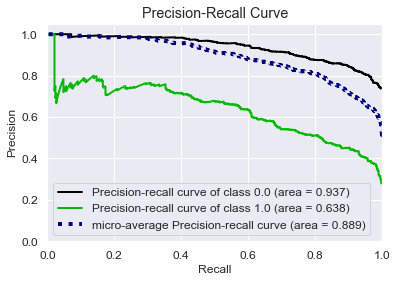

In [69]:
plot_precision_recall_curve(Y_test ,Y_lreg_pred_proba)

C:\Users\Thiago\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)


<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

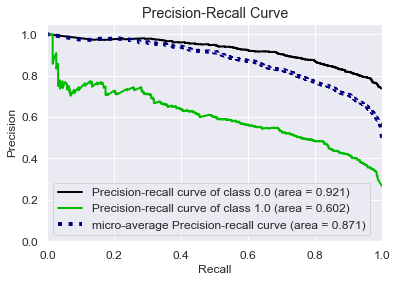

In [70]:
plot_precision_recall_curve(Y_test ,y_tree_pred_proba)

C:\Users\Thiago\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)


<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

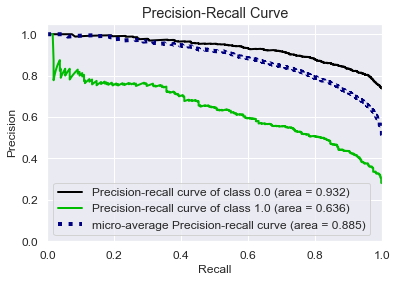

In [71]:
plot_precision_recall_curve(Y_test ,y_rf_pred_proba)

C:\Users\Thiago\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)


<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

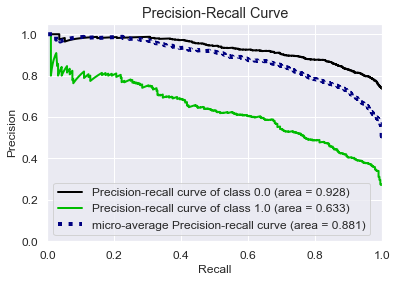

In [72]:
plot_precision_recall_curve(Y_test ,y_xgb_pred_proba)

C:\Users\Thiago\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)


<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

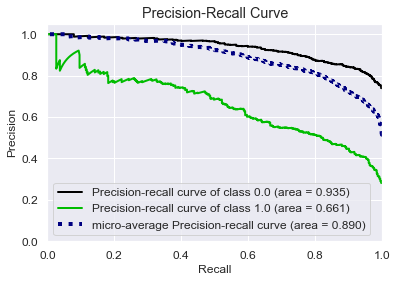

In [73]:
plot_precision_recall_curve(Y_test ,y_cat_pred_proba)

ROC Curve

C:\Users\Thiago\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

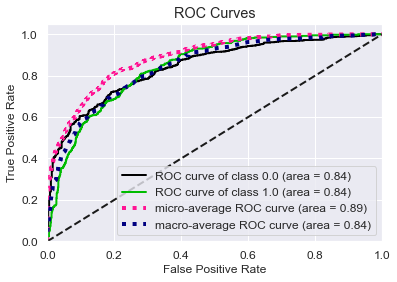

In [74]:
plot_roc_curve(Y_test, Y_lreg_pred_proba)

C:\Users\Thiago\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

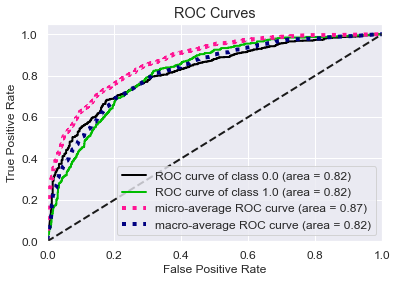

In [75]:
plot_roc_curve(Y_test, y_tree_pred_proba)

C:\Users\Thiago\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

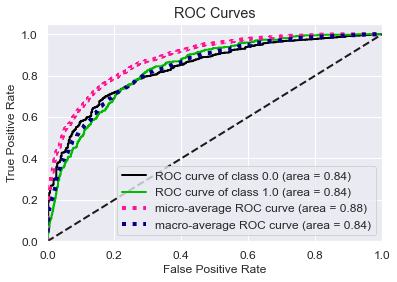

In [76]:
plot_roc_curve(Y_test, y_rf_pred_proba)

C:\Users\Thiago\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

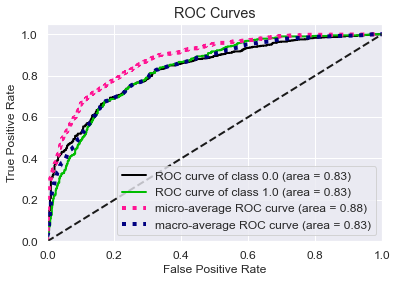

In [77]:
plot_roc_curve(Y_test, y_xgb_pred_proba)

C:\Users\Thiago\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

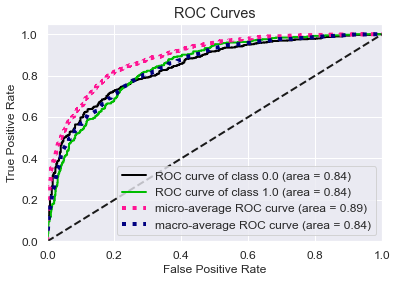

In [78]:
plot_roc_curve(Y_test, y_cat_pred_proba)

ks_statistic

<AxesSubplot:title={'center':'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

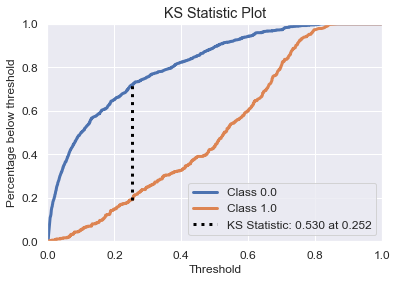

In [79]:
plot_ks_statistic(Y_test, Y_lreg_pred_proba)

<AxesSubplot:title={'center':'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

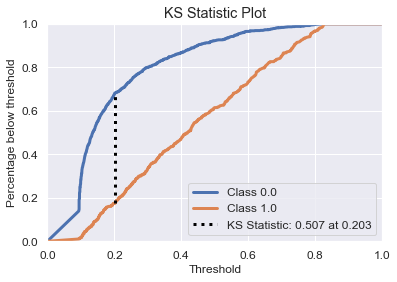

In [80]:
plot_ks_statistic(Y_test, y_tree_pred_proba)

<AxesSubplot:title={'center':'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

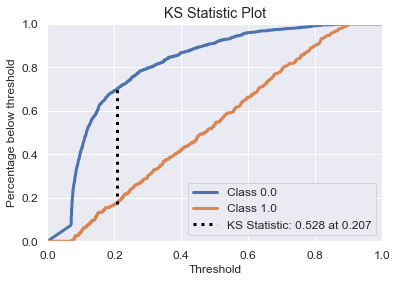

In [81]:
plot_ks_statistic(Y_test, y_rf_pred_proba)

<AxesSubplot:title={'center':'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

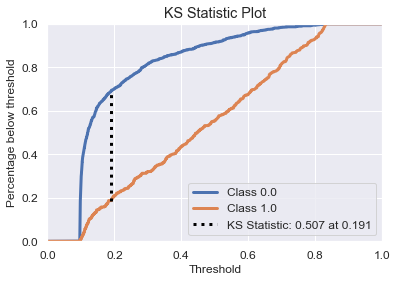

In [82]:
plot_ks_statistic(Y_test, y_xgb_pred_proba)

<AxesSubplot:title={'center':'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

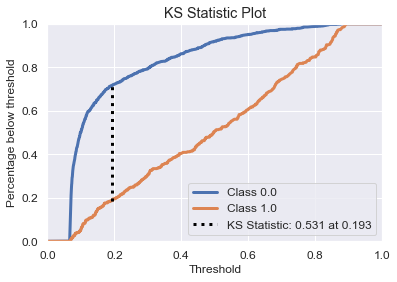

In [83]:
plot_ks_statistic(Y_test, y_cat_pred_proba)

### Otimização do modelo

In [84]:
param_grid = [{'n_estimators': [3 , 10 , 30], 'max_features':[2,4,6,8], }]

In [ ]:
grid_search= GridSearchCV(rf, param_grid, return_train_score=True )

In [ ]:
grid_search.fit(X_train, Y_train)